In [6]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Pastikan resource NLTK terunduh
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Baca dataset
df_article = pd.read_csv("../data/Hasil_Scraping_Gojek.csv")

# Gunakan hanya kolom 'Content'
df_article = df_article.rename(columns={'content': 'article_text'})
df_article = df_article.dropna(subset=['article_text']).reset_index(drop=True)

print("Jumlah artikel:", len(df_article))
df_article.head()


Jumlah artikel: 158


[nltk_data] Downloading package punkt to /Users/irfan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/irfan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/irfan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,authors,source,published_date,summary,article_text,url,tag,tanggal
0,"Tarif Ojol Naik 15 Persen, Pakar Transportasi ...",Rahajeng Kartika,beritajatim.com,2025-07-24 22:49:04+00:00,NaN,Yogyakarta (beritajatim.com)– Pemerintah melal...,https://beritajatim.com/tarif-ojol-naik-15-per...,Local News,02/07/2025
1,"Kenaikan Tarif Ojol 8–15 Persen Ditolak, Aplik...",NaN,beritanusantara.co,2025-07-04 08:59:37+00:00,NaN,"Beritanusantara.co, Jakarta – Rencana pemerint...",https://beritanusantara.co/kenaikan-tarif-ojol...,Economic,04/07/2025
2,"Penelitian Menyebutkan, 75% Pengguna Ojol Tola...",Tim Sindonews,daerah.sindonews.com,NaN,NaN,"Penelitian Menyebutkan, 75% Pengguna Ojol Tola...",https://daerah.sindonews.com/artikel/makassar/...,Academic,02/03/2025
3,Gojek Siap Kaji Perubahan Tarif Ojek Online Me...,Harian Jogja Digital Media,ekbis.harianjogja.com,2025-07-02 00:00:00,NaN,Gojek Siap Kaji Perubahan Tarif Ojek Online Me...,https://ekbis.harianjogja.com/read/2025/07/02/...,Economic,02/07/2025
4,"Kenaikan Tarif Ojol Sarat Risiko, Pemerintah P...","Rio Sandy Pradana, Penulis, Editor",ekonomi.bisnis.com,2025-07-01 15:07:28+07:00,NaN,RISED menilai penerapan kenaikan tarif ojol di...,https://ekonomi.bisnis.com/read/20250701/98/18...,Economic,01/07/2025


In [7]:

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()                                 # lowercase
    text = re.sub(r'<[^>]*>', ' ', text)                # hapus HTML
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)  # hapus URL
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)            # hapus angka & simbol
    text = re.sub(r'\s+', ' ', text).strip()            # hapus spasi berlebih
    return text

df_article['cleaned_text'] = df_article['article_text'].apply(clean_text)

print("🧹 Perbandingan Sebelum & Sesudah Cleaning:")
print(df_article[['article_text', 'cleaned_text']].head())


🧹 Perbandingan Sebelum & Sesudah Cleaning:
                                        article_text  \
0  Yogyakarta (beritajatim.com)– Pemerintah melal...   
1  Beritanusantara.co, Jakarta – Rencana pemerint...   
2  Penelitian Menyebutkan, 75% Pengguna Ojol Tola...   
3  Gojek Siap Kaji Perubahan Tarif Ojek Online Me...   
4  RISED menilai penerapan kenaikan tarif ojol di...   

                                        cleaned_text  
0  yogyakarta beritajatim com pemerintah melalui ...  
1  beritanusantara co jakarta rencana pemerintah ...  
2  penelitian menyebutkan pengguna ojol tolak ken...  
3  gojek siap kaji perubahan tarif ojek online me...  
4  rised menilai penerapan kenaikan tarif ojol di...  



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
✅ Analisis sentimen selesai!
                                        cleaned_text  polarity sentiment
0  yogyakarta beritajatim com pemerintah melalui ...  0.134883  positive
1  beritanusantara co jakarta rencana pemerintah ...  0.025484   neutral
2  penelitian menyebutkan pengguna ojol tolak ken...  0.135888  positive
3  gojek siap kaji perubahan tarif ojek online me...  0.074596  positive
4  rised menilai penerapan kenaikan tarif ojol di...  0.049615   neutral


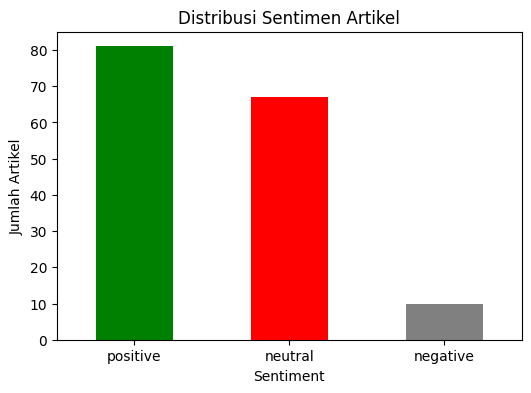

In [8]:
# Install package yang diperlukan
!pip install textblob deep-translator --quiet

# Import library
from textblob import TextBlob
from deep_translator import GoogleTranslator
import numpy as np
import pandas as pd
import time

# === FUNGSI TRANSLASI (aman & stabil) ===
def translate_text(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except Exception as e:
        print("⚠️ Terjemahan gagal:", e)
        return text

# === FUNGSI PEMOTONG TEKS PANJANG ===
def split_text_into_batches(text, max_words=500):
    if not isinstance(text, str):
        return []
    words = text.split()
    return [' '.join(words[i:i + max_words]) for i in range(0, len(words), max_words)]

# === FUNGSI HITUNG SENTIMEN ===
def get_sentiment_polarity_long(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0

    batches = split_text_into_batches(text)
    polarities = []

    for batch in batches:
        try:
            eng_text = translate_text(batch)
            blob = TextBlob(eng_text)
            scores = [s.sentiment.polarity for s in blob.sentences]
            if scores:
                polarities.append(np.mean(scores))
            time.sleep(0.3)  # jeda agar tidak kena limit API
        except Exception as e:
            print("⚠️ Gagal proses batch:", e)
            continue

    return np.mean(polarities) if polarities else 0.0

# === KLASIFIKASI SENTIMEN ===
def classify_sentiment(polarity, threshold=0.05):
    if polarity > threshold:
        return 'positive'
    elif polarity < -threshold:
        return 'negative'
    else:
        return 'neutral'

# === CONTOH DATA (hapus bagian ini kalau sudah punya df_article) ===
# df_article = pd.DataFrame({
#     'cleaned_text': [
#         'Gojek memberikan pelayanan yang luar biasa!',
#         'Saya kecewa dengan layanan aplikasi ini.',
#         'Aplikasi ini cukup membantu dalam kehidupan sehari-hari.'
#     ]
# })

# === JALANKAN ANALISIS SENTIMEN ===
df_article = df_article.dropna(subset=['cleaned_text'])
df_article['polarity'] = df_article['cleaned_text'].apply(get_sentiment_polarity_long)
df_article['sentiment'] = df_article['polarity'].apply(classify_sentiment)

print("✅ Analisis sentimen selesai!")
print(df_article[['cleaned_text', 'polarity', 'sentiment']].head(5))

# === OPSIONAL: VISUALISASI HASILNYA ===
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df_article['sentiment'].value_counts().plot(kind='bar', color=['green','red','gray'])
plt.title('Distribusi Sentimen Artikel')
plt.xlabel('Sentiment')
plt.ylabel('Jumlah Artikel')
plt.xticks(rotation=0)
plt.show()


Tokenization & Stopwords Removal

In [9]:
# ============================================================
# 🧹 STOPWORD & TOKENISASI DENGAN CUSTOM FILTER
# ============================================================

# Install NLTK kalau belum ada
!pip install nltk --quiet

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Unduh resource jika belum
nltk.download('stopwords')
nltk.download('punkt_tab')

# 🔹 Stopword Bahasa Indonesia dan Inggris
stop_id = set(stopwords.words('indonesian'))
stop_en = set(stopwords.words('english'))

# 🔹 Custom stopword (nama media, kata umum, proper noun, dll)
custom_stopwords = {
    'berita','com','jek','gojek','co','id','https','www','net','cnn','detik','tempo',
    'tribun','antara','liputan','kompas','sindo','republika','merdeka','indozone',
    'jawapos','beritajatim','beritanusantara','menurut','ujar','kata','tutur','ungkap',
    'bahwa','saat','akan','juga','masih','telah','agar','dalam','tersebut','terkait',
    'hingga','setelah','sebagai','pada','oleh','ini','itu','untuk','dengan','para',
    'karena','yakni','heru','budi','jokowi','jakarta','indonesia','go', 'grab','pt'
}

# 🔹 Gabungkan semua stopword
stop_words = stop_id.union(stop_en).union(custom_stopwords)

# 🔹 Fungsi bersih + tokenisasi
def tokenize_and_remove_stopwords(text):
    # Hapus karakter non-huruf
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text))
    # Tokenisasi
    tokens = word_tokenize(text.lower())
    # Filter stopword + minimal panjang kata 3
    filtered = [w for w in tokens if w not in stop_words and len(w) > 2]
    return filtered

# 🔹 Terapkan ke dataframe
df_article['tokens'] = df_article['cleaned_text'].astype(str).apply(tokenize_and_remove_stopwords)

# 🔹 Cek hasil
print("🔤 Contoh hasil tokenisasi (custom stopwords aktif):")
print(df_article[['cleaned_text', 'tokens']].head())



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
🔤 Contoh hasil tokenisasi (custom stopwords aktif):
                                        cleaned_text  \
0  yogyakarta beritajatim com pemerintah melalui ...   
1  beritanusantara co jakarta rencana pemerintah ...   
2  penelitian menyebutkan pengguna ojol tolak ken...   
3  gojek siap kaji perubahan tarif ojek online me...   
4  rised menilai penerapan kenaikan tarif ojol di...   

                                              tokens  
0  [yogyakarta, pemerintah, kementerian, perhubun...  
1  [rencana, pemerintah, menaikkan, tarif, dasar,...  
2  [penelitian, pengguna, ojol, tolak, kenaikan, ...  
3  [kaji, perubahan, tarif, ojek, online, mengiku...  
4  [rised, menilai, penerapan, kenaikan, tarif, o...  


[nltk_data] Downloading package stopwords to /Users/irfan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/irfan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
# Install Sastrawi kalau belum ada (jalankan sekali saja di Colab)
!pip install Sastrawi --quiet

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Inisialisasi stemmer Bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# 🔹 Daftar kata penting yang tidak boleh di-stem (dilindungi)
protect_words = [
    'gojek', 'goride', 'gocar', 'gopay', 'gopaylater', 'gosend',
    'gomart', 'gofood', 'driver', 'pelanggan', 'layanan', 
    'ojek', 'aplikasi', 'pengemudi', 'promo', 'transaksi', 
    'fitur', 'tarif', 'pesanan', 'akun', 'mitra'
]

# 🔹 Fungsi stemming dengan pengecualian kata penting
def stem_tokens(tokens):
    stemmed = []
    for token in tokens:
        if token in protect_words:
            stemmed.append(token)  # kata penting tetap dipertahankan
        else:
            stemmed.append(stemmer.stem(token))  # lakukan stemming normal
    return stemmed

# 🔹 Terapkan fungsi stemming ke dataframe
df_article['stemmed_tokens'] = df_article['tokens'].apply(stem_tokens)

# 🔹 Gabungkan token hasil stemming jadi kalimat
df_article['stemmed_text'] = df_article['stemmed_tokens'].apply(lambda x: ' '.join(x))

print("🪶 Contoh hasil stemming (dengan kata penting dipertahankan):")
df_article[['tokens', 'stemmed_tokens', 'stemmed_text']].head(5)



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
🪶 Contoh hasil stemming (dengan kata penting dipertahankan):


,tokens,stemmed_tokens,stemmed_text
0,"[yogyakarta, pemerintah, kementerian, perhubun...","[yogyakarta, perintah, menteri, hubung, bijak,...",yogyakarta perintah menteri hubung bijak naik ...
1,"[rencana, pemerintah, menaikkan, tarif, dasar,...","[rencana, perintah, naik, tarif, dasar, ojek, ...",rencana perintah naik tarif dasar ojek online ...
2,"[penelitian, pengguna, ojol, tolak, kenaikan, ...","[teliti, guna, ojol, tolak, naik, tarif, ilust...",teliti guna ojol tolak naik tarif ilustrasi tu...
3,"[kaji, perubahan, tarif, ojek, online, mengiku...","[kaji, ubah, tarif, ojek, online, ikut, regula...",kaji ubah tarif ojek online ikut regulasi peri...
4,"[rised, menilai, penerapan, kenaikan, tarif, o...","[rised, nilai, terap, naik, tarif, ojol, nilai...",rised nilai terap naik tarif ojol nilai risiko...


In [11]:
# =====================================================
# 🟢 Simpan Hasil Analisis Sentimen Berita Gojek ke CSV
# =====================================================

# Urutan kolom tanpa publish_date / Date
final_cols = [
    'No', 'Title', 'Source', 'URL',
    'article_text', 'tanggal', 'cleaned_text',
    'tokens', 'stemmed_tokens', 'stemmed_text',
    'polarity', 'sentiment', 'tag'
]

# Cek kolom yang memang tersedia di dataframe
available_cols = [c for c in final_cols if c in df_article.columns]

# Simpan ke file CSV dengan encoding aman untuk Excel
df_article[available_cols].to_csv("cleaned_gojek_text_final.csv", index=False, encoding='utf-8-sig')

print("✅ File 'cleaned_gojek_text_final.csv' berhasil disimpan!")
print(f"Kolom disertakan: {available_cols}")
print(f"Total artikel tersimpan: {len(df_article)}")


✅ File 'cleaned_gojek_text_final.csv' berhasil disimpan!
Kolom disertakan: ['article_text', 'tanggal', 'cleaned_text', 'tokens', 'stemmed_tokens', 'stemmed_text', 'polarity', 'sentiment', 'tag']
Total artikel tersimpan: 158


In [12]:
# =====================================================
# 🟢 Simpan Hasil Analisis Sentimen Berita Gojek ke CSV & Excel
# =====================================================
!pip install openpyxl --quiet

# Urutan kolom tanpa publish_date / Date
final_cols = [
    'No', 'Title', 'Source', 'URL',
    'article_text', 'tanggal', 'cleaned_text',
    'tokens', 'stemmed_tokens', 'stemmed_text',
    'polarity', 'sentiment', 'tag'
]

# Cek kolom yang memang tersedia di dataframe
available_cols = [c for c in final_cols if c in df_article.columns]

# =====================================================
# Simpan ke file CSV
# =====================================================
df_article[available_cols].to_csv(
    "cleaned_gojek_text_final.csv",
    index=False,
    encoding='utf-8-sig'
)

# =====================================================
# Simpan ke file Excel (.xlsx)
# =====================================================
df_article[available_cols].to_excel(
    "cleaned_gojek_text_final.xlsx",
    index=False,
    engine='openpyxl'
)

print("✅ File berhasil disimpan dalam dua format:")
print("   - cleaned_gojek_text_final.csv")
print("   - cleaned_gojek_text_final.xlsx")
print(f"Kolom disertakan: {available_cols}")
print(f"Total artikel tersimpan: {len(df_article)}")



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
✅ File berhasil disimpan dalam dua format:
   - cleaned_gojek_text_final.csv
   - cleaned_gojek_text_final.xlsx
Kolom disertakan: ['article_text', 'tanggal', 'cleaned_text', 'tokens', 'stemmed_tokens', 'stemmed_text', 'polarity', 'sentiment', 'tag']
Total artikel tersimpan: 158


  sentiment         tag
0   neutral  Local News
1   neutral    Economic
2  positive    Academic
3  positive    Economic
4   neutral    Economic


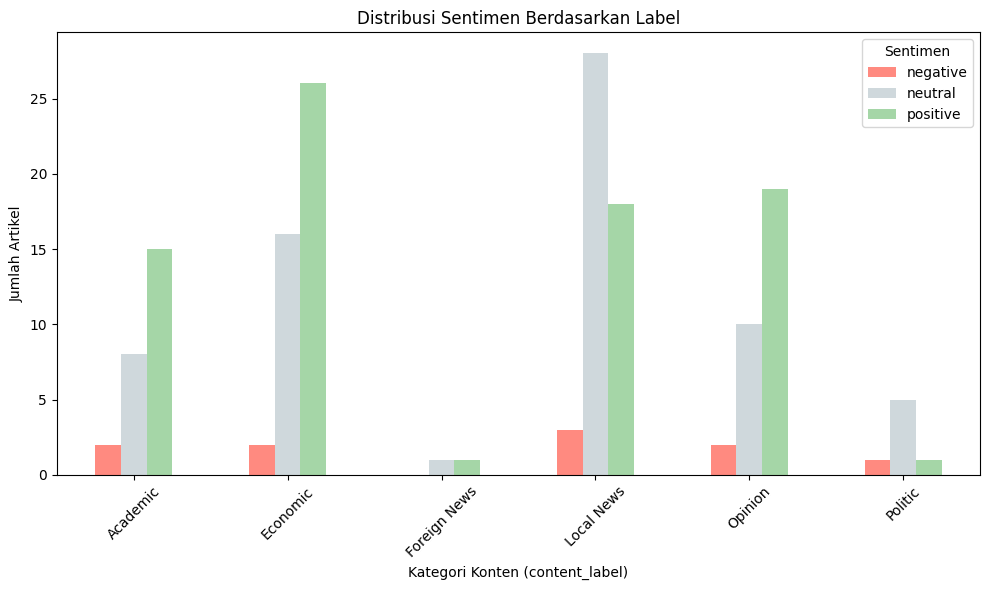

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Baca file Excel
df = pd.read_excel("../Data/cleaned_gojek_text_final.xlsx")

# 2. Lihat isi kolom untuk memastikan
print(df[['sentiment', 'tag']].head())

# 3. Hitung jumlah data berdasarkan kombinasi sentiment dan content_label
count_data = df.groupby(['tag', 'sentiment']).size().unstack(fill_value=0)

# 4. Buat visualisasi (bar chart) dengan warna khusus per sentimen
colors = {
    'negative': '#FF8A80',  # pastel red
    'neutral': '#CFD8DC',   # light gray-blue
    'positive': '#A5D6A7'   # mint green
}

count_data.plot(kind='bar', figsize=(10,6), color=[colors[col] for col in count_data.columns])

# 5. Tambahkan judul dan label
plt.title('Distribusi Sentimen Berdasarkan Label')
plt.xlabel('Kategori Konten (content_label)')
plt.ylabel('Jumlah Artikel')
plt.legend(title='Sentimen')
plt.xticks(rotation=45)
plt.tight_layout()

# 6. Tampilkan grafik
plt.show()

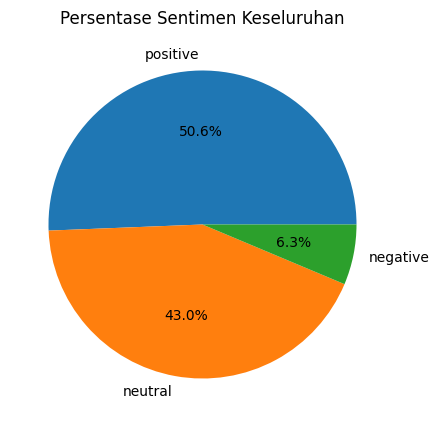

In [14]:
# Pie chart total sentimen
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5))
plt.title('Persentase Sentimen Keseluruhan')
plt.ylabel('')
plt.show()


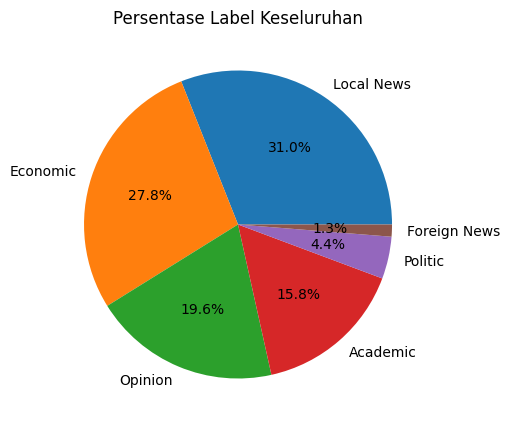

In [15]:

# Pie chart opini
df['tag'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5))
plt.title('Persentase Label Keseluruhan')
plt.ylabel('')
plt.show()